# Library and Dataset Preparation

In [28]:
import cv2
import numpy as np
import os
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mahotas as mt
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("All library imported.")

All library imported.


In [ ]:
dataset_path = r"D:\dataset\data sekunder"

In [30]:
categories = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print("Category founded:", categories)

Category founded: ['busuk daun', 'jamur daun', 'sehat', 'septoria']


# Image Preprocessing and Segmentation

In [31]:
def preprocess_segment(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image from path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (512, 512))
    brightness = 5
    adjusted_image = cv2.convertScaleAbs(resized_image, alpha=1, beta=brightness)
    blurred_image = cv2.GaussianBlur(adjusted_image, (7, 7), 0)
    hsv = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)

    lower_green = np.array([35, 30, 30])
    upper_green = np.array([90, 255, 255])
    lower_brown = np.array([10, 30, 10])
    upper_brown = np.array([80, 255, 255])
    lower_yellow = np.array([10, 50, 40])
    upper_yellow = np.array([40, 255, 255])

    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    mask_combined = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_brown, mask_yellow))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_cleaned = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_mask = np.zeros_like(mask_cleaned)
    min_contour_area = 2500
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if area > min_contour_area and 0.1 < aspect_ratio < 3.0:
            cv2.drawContours(cleaned_mask, [contour], -1, 255, thickness=cv2.FILLED)

    segmented = cv2.bitwise_and(resized_image, resized_image, mask=cleaned_mask)

    return segmented

# Feature Extraction

In [32]:
from math import radians
bins = 8

def extract_hsv_histogram(segmented):
    hsv = cv2.cvtColor(segmented, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])
    hist_features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
    return hist_features / np.sum(hist_features)

def extract_glcm_features(segmented):
    gray = cv2.cvtColor(segmented, cv2.COLOR_RGB2GRAY)
    angles = [radians(0), radians(45), radians(90), radians(135)]
    glcm = graycomatrix(gray, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)

    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

    return np.array([contrast, correlation, energy, homogeneity])

In [33]:
X, y = [], []

for category in categories:
    category_path = os.path.join(dataset_path, category)

    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        
        segmented = preprocess_segment(image_path)
        if segmented is not None:
            hsv_features = extract_hsv_histogram(segmented)
            glcm_features = extract_glcm_features(segmented)

            features = np.concatenate((hsv_features, glcm_features))
            X.append(features)
            y.append(category)

X = np.array(X)
y = np.array(y)

print(f"Dataset prepared with {X.shape[0]} samples dan {X.shape[1]} fitur.")

np.savez("dataset_tomat_features.npz", X=X, y=y)

Dataset prepared with 4000 samples dan 28 fitur.


In [34]:
data = np.load("dataset_tomat_features.npz", allow_pickle=True)
X, y = data["X"], data["y"]

print(f"Dataset loaded with {X.shape[0]} sampeles and {X.shape[1]} fitur.")

Dataset loaded with 4000 sampeles and 28 fitur.


In [35]:
# Tampilkan semua label unik
unique_labels = np.unique(y)
print("Unique labels in dataset:", unique_labels)

Unique labels in dataset: ['busuk daun' 'jamur daun' 'sehat' 'septoria']


# Model Training

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**SVM**

In [38]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [ 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf'],
}

In [39]:
svm = SVC()
grid_search = GridSearchCV(svm, param_grid,cv=5,scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [40]:
best_svm = grid_search.best_estimator_

In [41]:
y_pred = best_svm.predict(X_test)

**KNN**

In [42]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [43]:
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
print("\nBest Parameters KNN:", grid_search_knn.best_params_)


Best Parameters KNN: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.8653125 0.8653125 0.8565625 0.8615625 0.854375  0.8615625 0.849375
 0.86      0.8425    0.8546875 0.834375  0.84875   0.825625  0.840625
       nan 0.8721875       nan 0.8671875       nan 0.86625         nan
 0.856875        nan 0.8559375       nan 0.85125         nan 0.8415625]
  warnings.warn(


**Random Forest**

In [44]:
param_grid_rf = {
    'n_estimators': [1, 10, 50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

In [45]:

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("\nBest Parameters Random Forest:", grid_search_rf.best_params_)


Best Parameters Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


**Naive Bayes & Decision Tree**

In [46]:
nb = GaussianNB()
dt = DecisionTreeClassifier(random_state=42)

# Final Evaluation

In [47]:
models = {
    "SVM": best_svm,
    "KNN": best_knn,
    "Random Forest": best_rf,
    "Naive Bayes": nb,
    "Decision Tree": dt
}

In [48]:
import time

results = {}
for name, model in models.items():
    print(f"\n{'='*45}\nModel: {name}")
    
    start_train = time.perf_counter()
    model.fit(X_train, y_train)
    end_train = time.perf_counter()
    training_time = end_train - start_train
    
    start_test = time.perf_counter()
    y_pred_test = model.predict(X_test)
    end_test = time.perf_counter()
    testing_time = end_test - start_test

    # Hitung akurasi
    y_pred_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    print(f"Akurasi Training : {train_acc*100:.2f}%")
    print(f"Akurasi Testing  : {test_acc*100:.2f}%")
    print(f"Waktu Training   : {training_time:.6f} detik")
    print(f"Waktu Testing    : {testing_time:.6f} detik")

    results[name] = {
        "train_acc": train_acc,
        "test_acc": test_acc,
        "train_time": training_time,
        "test_time": testing_time
    }


Model: SVM
Akurasi Training : 96.97%
Akurasi Testing  : 93.75%
Waktu Training   : 0.130820 detik
Waktu Testing    : 0.065138 detik

Model: KNN
Akurasi Training : 100.00%
Akurasi Testing  : 87.88%
Waktu Training   : 0.002030 detik
Waktu Testing    : 0.023172 detik

Model: Random Forest
Akurasi Training : 100.00%
Akurasi Testing  : 93.12%
Waktu Training   : 2.568059 detik
Waktu Testing    : 0.022079 detik

Model: Naive Bayes
Akurasi Training : 62.19%
Akurasi Testing  : 61.88%
Waktu Training   : 0.004652 detik
Waktu Testing    : 0.000651 detik

Model: Decision Tree
Akurasi Training : 100.00%
Akurasi Testing  : 81.38%
Waktu Training   : 0.105790 detik
Waktu Testing    : 0.000461 detik


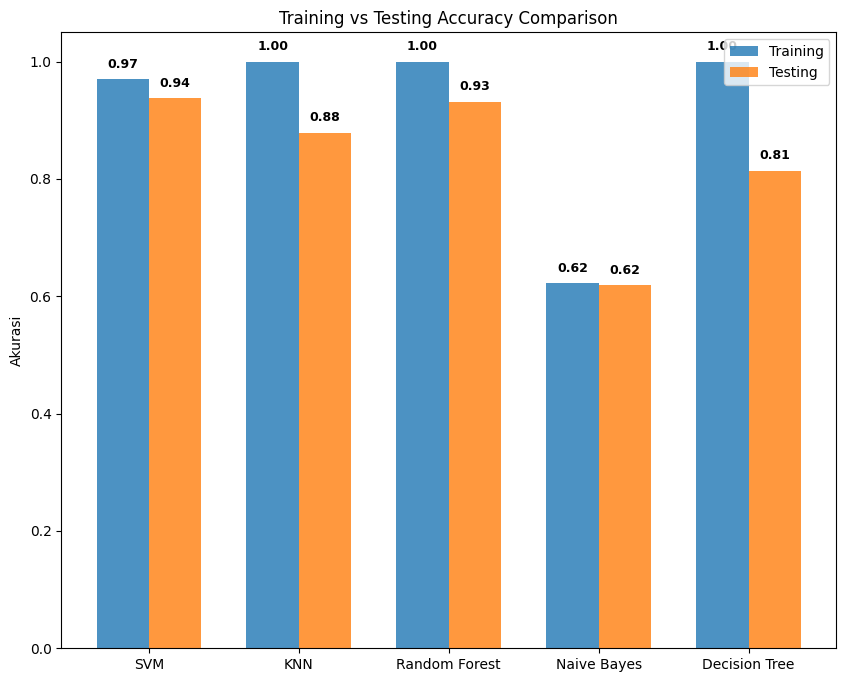

In [49]:
plt.figure(figsize=(10, 8))
labels = list(results.keys())
train_accs = [results[m]["train_acc"] for m in labels]
test_accs = [results[m]["test_acc"] for m in labels]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Training', alpha=0.8)
plt.bar(x + width/2, test_accs, width, label='Testing', alpha=0.8)

plt.xticks(x, labels)
plt.ylabel("Akurasi")
plt.ylim(0, 1.05)
plt.title("Training vs Testing Accuracy Comparison")
plt.legend()

for i, acc in enumerate(train_accs):
    plt.text(i - width/2, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=9, fontweight='bold')
for i, acc in enumerate(test_accs):
    plt.text(i + width/2, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=9, fontweight='bold')

plt.show()

# Save and Load Model

In [50]:
joblib.dump(best_svm, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\nSVM model saved successfully as 'svm_model.pkl' and 'scaler.pkl'.")


SVM model saved successfully as 'svm_model.pkl' and 'scaler.pkl'.


In [51]:
svm_model = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")

def predict_tomato_disease(features):
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    prediction = svm_model.predict(features)[0]
    return prediction

# Save Feature Extraction Dataset as CSV

In [52]:
data = np.column_stack((X, y))
hsv_columns = [f'H_bin_{i}' for i in range(bins)] + \
              [f'S_bin_{i}' for i in range(bins)] + \
              [f'V_bin_{i}' for i in range(bins)]
glcm_columns = ['contrast', 'correlation', 'energy', 'homogeneity']
columns = hsv_columns + glcm_columns + ['label']
df = pd.DataFrame(data, columns=columns)
df.to_csv("feature-extraction.csv", index=False)

print("Feature extraction dataset saved successfully as CSV with", len(columns), "column.")

Feature extraction dataset saved successfully as CSV with 29 column.


# Load Feature Extraction Dataset

In [53]:
data = pd.read_csv('feature-extraction.csv')

In [54]:
filtered_data_busuk_daun = data[data['label'] == 'busuk daun'].head(3)
filtered_data_jamur_daun = data[data['label'] == 'jamur daun'].head(3)
filtered_data_sehat = data[data['label'] == 'sehat'].head(3)
filtered_data_septoria = data[data['label'] == 'septoria'].head(3)
filtered_data = pd.concat([filtered_data_busuk_daun, filtered_data_jamur_daun, filtered_data_sehat, filtered_data_septoria])
pd.set_option('display.max_columns', 29)
filtered_data

,H_bin_0,H_bin_1,H_bin_2,H_bin_3,H_bin_4,H_bin_5,H_bin_6,H_bin_7,S_bin_0,S_bin_1,S_bin_2,S_bin_3,S_bin_4,S_bin_5,S_bin_6,S_bin_7,V_bin_0,V_bin_1,V_bin_2,V_bin_3,V_bin_4,V_bin_5,V_bin_6,V_bin_7,contrast,correlation,energy,homogeneity,label
0,0.259430,0.027602,0.046215,0.000000,0.000000,0.000000,0.000036,0.000051,0.257351,0.015481,0.051412,0.008556,0.000464,0.000042,0.000015,0.000011,0.256622,0.000590,0.001252,0.026087,0.037041,0.010292,0.001447,0.000001,79.932208,0.986372,0.767009,0.813931,busuk daun
1,0.222651,0.046193,0.064372,0.000036,0.000011,0.000001,0.000003,0.000066,0.216170,0.010535,0.059751,0.028653,0.010282,0.004589,0.002022,0.001331,0.220193,0.004391,0.012440,0.030755,0.050070,0.014736,0.000741,0.000006,121.679867,0.981770,0.643287,0.688384,busuk daun
2,0.258293,0.027006,0.048035,0.000000,0.000000,0.000000,0.000000,0.000000,0.258078,0.003440,0.008963,0.042252,0.018449,0.002151,0.000000,0.000000,0.257891,0.000248,0.002001,0.034485,0.033685,0.004927,0.000095,0.000000,47.282026,0.990074,0.771604,0.823026,busuk daun
1000,0.267882,0.003531,0.034288,0.027490,0.000142,0.000000,0.000000,0.000000,0.268125,0.005090,0.019225,0.033525,0.006252,0.000994,0.000116,0.000006,0.267961,0.003609,0.029443,0.027726,0.004531,0.000062,0.000001,0.000000,42.751624,0.981563,0.801365,0.841208,jamur daun
1001,0.228209,0.031399,0.073518,0.000155,0.000028,0.000019,0.000005,0.000000,0.226566,0.008999,0.033569,0.041890,0.014666,0.004499,0.002195,0.000949,0.234027,0.017120,0.041822,0.032003,0.007620,0.000730,0.000011,0.000000,69.250305,0.977365,0.674477,0.731167,jamur daun
1002,0.228678,0.085578,0.018523,0.000065,0.000075,0.000123,0.000141,0.000150,0.222551,0.002981,0.006203,0.029676,0.045714,0.015188,0.005333,0.005689,0.234191,0.006220,0.010911,0.030968,0.040011,0.010698,0.000334,0.000000,81.431420,0.985444,0.662351,0.732127,jamur daun
2000,0.192088,0.000884,0.139737,0.000575,0.000050,0.000000,0.000000,0.000000,0.192603,0.080858,0.057921,0.001736,0.000202,0.000014,0.000000,0.000000,0.192088,0.000551,0.002153,0.075106,0.062668,0.000768,0.000000,0.000000,58.175950,0.991072,0.573290,0.673231,sehat
2001,0.193340,0.025281,0.114614,0.000010,0.000013,0.000004,0.000000,0.000071,0.188491,0.007000,0.076120,0.046764,0.009809,0.003309,0.001486,0.000355,0.196115,0.002239,0.008728,0.028493,0.066291,0.030102,0.001355,0.000010,160.343748,0.980104,0.559888,0.619783,sehat
2002,0.226930,0.037978,0.068174,0.000003,0.000006,0.000062,0.000104,0.000076,0.224317,0.048278,0.035714,0.013602,0.005259,0.002357,0.001887,0.001919,0.228790,0.010153,0.022982,0.031281,0.027096,0.011113,0.001856,0.000061,181.606302,0.968361,0.664608,0.696163,sehat
3000,0.222677,0.059772,0.050746,0.000029,0.000001,0.000006,0.000020,0.000081,0.217036,0.003456,0.005969,0.016426,0.055400,0.027879,0.005617,0.001551,0.217105,0.003958,0.009469,0.038509,0.059212,0.004812,0.000267,0.000001,62.172134,0.989305,0.646928,0.726435,septoria


# 📊 Conclusion of Tomato Plant Disease Classification Algorithm Comparison

Below are the evaluation results of **Training** and **Testing accuracy** from several classification algorithms:

---

## 🔹 Support Vector Machine (SVM)
- **Training:** `0.97`  
- **Testing:** `0.94`  

---

## 🔹 K-Nearest Neighbor (KNN)
- **Training:** `1.00`  
- **Testing:** `0.88`  

---

## 🔹 Random Forest
- **Training:** `1.00`  
- **Testing:** `0.93`  

---

## 🔹 Naive Bayes
- **Training:** `0.62`  
- **Testing:** `0.62`  

---

## 🔹 Decision Tree
- **Training:** `1.00`  
- **Testing:** `0.81`  

---

## 📌 Summary Table

| Algorithm         | Training | Testing |
|-------------------|----------|---------|
| **SVM**           | 0.97     | 0.94    |
| **KNN**           | 1.00     | 0.88    |
| **Random Forest** | 1.00     | 0.93    |
| **Naive Bayes**   | 0.62     | 0.62    |
| **Decision Tree** | 1.00     | 0.81    |